# Load Profiles

Get standard load profiles from https://www.bdew.de/energie/standardlastprofile-strom/.
Download .zip folder, we use only the Repräsentative Profile VDEW here, renamed to
representative_profiles_vdew.xls.

In [1]:
from pathlib import Path
import datetime

import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
lastprofile_file = Path('.') / 'data' / 'representative_profiles_vdew.xls'
assert lastprofile_file.is_file(), f'Did not find file with representative load profiles at {lastprofile_file}'

In [5]:
def get_profile_from_file(fp: Path, type: str = 'H0') -> pd.DataFrame:
    """From the VDEW profiles xls file, get one sheet.

    Args:
        fp (Path): Path to .xls file.
        type (str): Profile type corresponding to the sheet name in the file.
            Defaults to H0.

    Returns:
        pd.DataFrame: DataFrame with column Multiindex Season
            (Winter, Sommer, Übergangszeit) and Daytype (Samstag, Sonntag, Werktag),
            and Index Time from 0:15 to 24:00 in 15 minute intervals.
    """
    df = pd.read_excel(fp, sheet_name=type, header=[1,2], index_col=0, nrows=24*4)

    return df

In [6]:
i = pd.Index(['00:15', '00:30'])
i = i.map(lambda x: datetime.time.fromisoformat(x))

In [7]:
h0_profiles = get_profile_from_file(lastprofile_file, 'H0')

In [9]:
h0_profiles.head()

H0        Winter                  Sommer                 Übergangszeit  \
[W]      Samstag Sonntag Werktag Samstag Sonntag Werktag       Samstag   
00:15:00    70.8    87.5    67.6    89.8   100.1    86.3          80.2   
00:30:00    68.2    81.1    60.8    84.9    92.5    76.9          75.1   
00:45:00    65.9    75.0    54.9    80.7    85.9    68.8          70.7   
01:00:00    63.3    69.1    49.9    76.6    79.9    62.4          66.6   
01:15:00    59.5    63.4    46.2    71.7    74.1    58.0          62.3   

H0                        
[W]      Sonntag Werktag  
00:15:00    93.4    77.8  
00:30:00    86.8    69.6  
00:45:00    81.2    62.4  
01:00:00    75.7    56.6  
01:15:00    70.1    52.5

In [8]:
# Constants
AT_HOLIDAYS = holidays.AUT()

# Dynamization function coefficients
A4=-3.92e-10
A3=0.00000032
A2=-0.0000702
A1=0.0021
A0=1.24

In [11]:
def dynamize_day(ser: pd.Series, dayofyear: int) -> pd.Series:
    """Dynamize profile 15 minute series by dayofyear."""
    dynamization_value = (
        np.power(dayofyear, 4) * A4
        + np.power(dayofyear, 3) * A3
        + np.power(dayofyear, 2) * A2
        + dayofyear * A1
        + A0
    )
    return ser * dynamization_value

In [29]:
def dynamization_value (dayofyear): 
    return (
        np.power(dayofyear, 4) * A4
        + np.power(dayofyear, 3) * A3
        + np.power(dayofyear, 2) * A2
        + dayofyear * A1
        + A0
    )

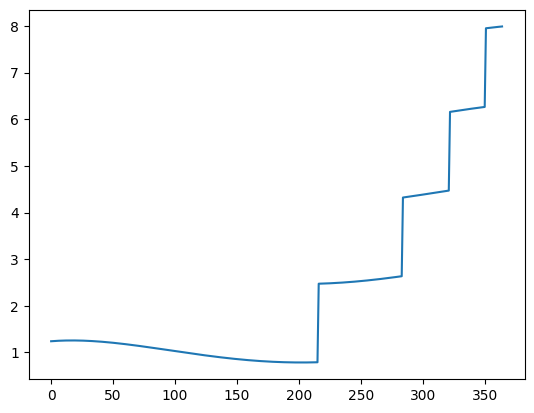

In [30]:
x = range(0, 365)
y = [dynamization_value(x_) for x_ in x]

plt.plot(x, y)

In [12]:
def load_profile_for_day(
    day: datetime.date, profile_df: pd.DataFrame, dynamize: bool=False
) -> pd.Series:
    """Get the 15 minute load profile for a single day.

    Args:
        day (datetime.date): Date for which to get the load profile.
        profile_df (pd.DataFrame): In the format as given by get_profile_from_file.
        dynamize (bool): Should dynamization by the 4th-grade polynomial dynamization
            function for day of year be applied. This should be only done for H0. Defaults to False.

    Returns:
        pd.Series: Series with Watt values every 15 minutes, and a pd.DatetimeIndex.
    """
    if (day <= datetime.date(day.year, 3, 20)) or (day >= datetime.date(day.year, 11, 1)):
        season = 'Winter'
    elif (day >= datetime.date(day.year, 5, 15)) and (day <= datetime.date(day.year, 9, 14)):
        season =  'Sommer'
    else:
        season = "Übergangszeit"
        
    if (day in AT_HOLIDAYS) or (day.isoweekday == 7):
        weekday = 'Sonntag'
    elif (day.isoweekday == 6) or (day in [datetime.date(day.year, 12, 24), datetime.date(day.year, 12, 31)]):
        weekday = 'Samstag'
    else:
        weekday = 'Werktag'

    df = profile_df[season][weekday]
    def combine_day_time(time: datetime.time) -> datetime.datetime:
        """Combine day and time and account for 00:00 being on the next day"""
        dt = datetime.datetime.combine(day, time)
        if time == datetime.time(0, 0):
            dt = dt + datetime.timedelta(days=1)
        return dt
    df.index = df.index.map(combine_day_time)

    if dynamize:
        df = dynamize_day(df, df.index.dayofyear[0])

    return df

In [13]:
# datetime.datetime.combine(datetime.date(2020, 1, 2), datetime.time(24, 0))

In [14]:
datetime.date(2020, 1, 4).day

4

In [15]:
df = load_profile_for_day(datetime.date(2020, 5, 30), h0_profiles, True)

dayofyear = df.index.dayofyear[0]

In [16]:
def get_load_profile(
    fp: Path, from_: datetime.date | str, to: datetime.date | str, type: str='H0'
) -> pd.Series:
    """Get a 15 minutes load profiles for given time span.

    Args:
        fp (Path): Path to .xls file.
        from_ (datetime.date | str): Start date.
        to (datetime.date | str): End date.
        type (str): Profile type corresponding to the sheet name in the file.
            Defaults to H0.

    Returns:
        pd.Series: Series with Watt values every 15 minutes between from_ date
            and to date, with a pd.DatetimeIndex.
    """
    profile_df = get_profile_from_file(fp, type)
    dynamize = (type == 'H0')
    
    daily_profiles = []
    for day in pd.date_range('2015-01-01', datetime.date(2015, 12, 31), freq='D'):
        daily_profiles.append(load_profile_for_day(day.date(), profile_df, dynamize))

    return pd.concat(daily_profiles, axis='index')

In [17]:
h0profile = get_load_profile(
    lastprofile_file, from_=datetime.date(2015, 1, 1), to=datetime.date(2015, 12, 31), type='H0'
)

<Axes: >

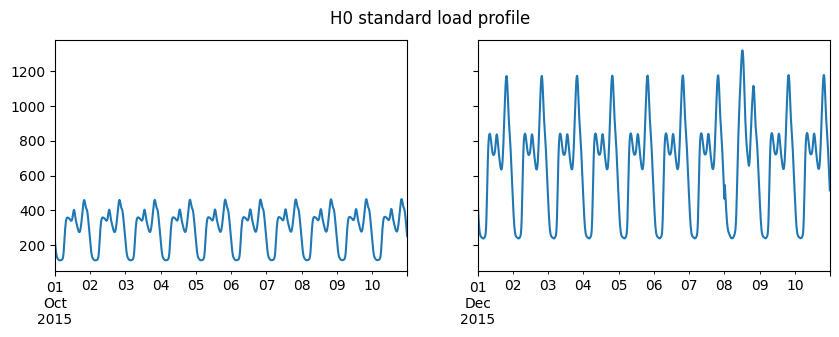

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
fig.suptitle('H0 standard load profile')
h0profile['2015-10-01' : '2015-10-10'].plot(ax=axs[0])
h0profile['2015-12-01' : '2015-12-10'].plot(ax=axs[1])

<Axes: >

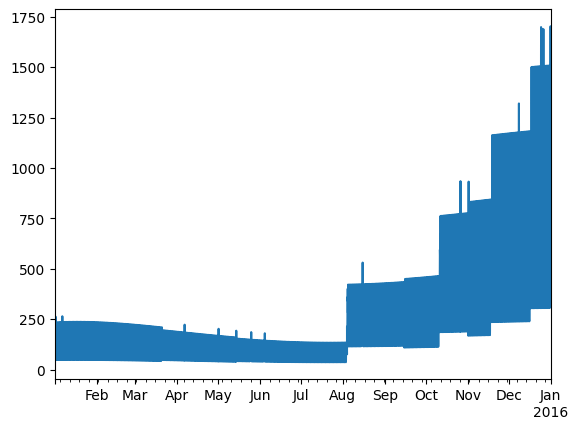

In [21]:
# Doesn't look too good...
h0profile.plot()

In [22]:
g0profile = get_load_profile(
    lastprofile_file, from_=datetime.date(2015, 1, 1), to=datetime.date(2015, 12, 31), type='G0'
)

<Axes: >

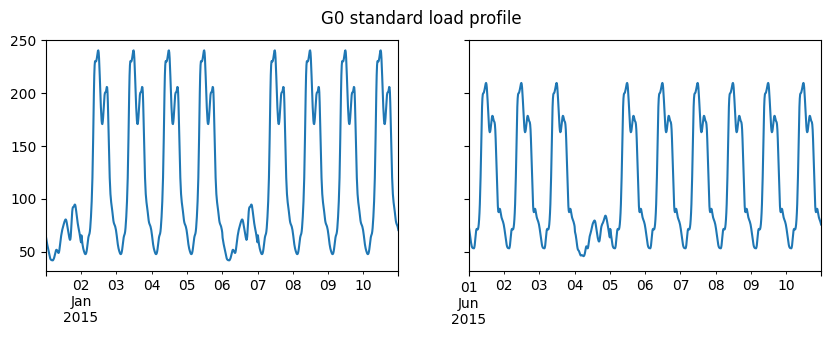

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
fig.suptitle('G0 standard load profile')
g0profile['2015-01-01' : '2015-01-10'].plot(ax=axs[0])
g0profile['2015-06-01' : '2015-06-10'].plot(ax=axs[1])

<Axes: >

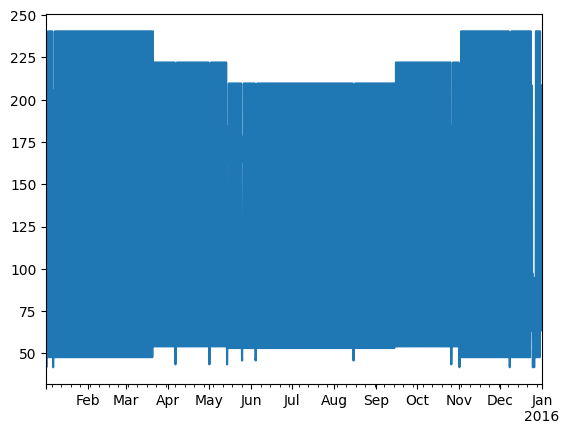

In [24]:
g0profile.plot()